# Azure Computer Vision 4 (Florence)
## Fashion images clustering demo with Azure Computer Vision 4 Florence

<img src="https://github.com/retkowsky/images/blob/master/florence/fashionheader.png?raw=true">
<br>
<i>Note: this image was generated with Azure Open AI Dall-e 2</i>

### Visual search with vector embeddings
**Vector embeddings** are a way of representing content such as text or images as vectors of real numbers in a high-dimensional space. These embeddings are often learned from large amounts of textual and visual data using machine learning algorithms like neural networks. Each dimension of the vector corresponds to a different feature or attribute of the content, such as its semantic meaning, syntactic role, or context in which it commonly appears. By representing content as vectors, we can perform mathematical operations on them to compare their similarity or use them as inputs to machine learning models.

<img src="https://github.com/retkowsky/images/blob/master/florence/embeddings.jpg?raw=true">

### Business applications
- **Digital asset management**: Image retrieval can be used to manage large collections of digital images, such as in museums, archives, or online galleries. Users can search for images based on visual features and retrieve the images that match their criteria.
- **Medical image retrieval**: Image retrieval can be used in medical imaging to search for images based on their diagnostic features or disease patterns. This can help doctors or researchers to identify similar cases or track disease progression.
- **Security and surveillance**: Image retrieval can be used in security and surveillance systems to search for images based on specific features or patterns, such as in, people & object tracking, or threat detection.
- **Forensic image retrieval**: Image retrieval can be used in forensic investigations to search for images based on their visual content or metadata, such as in cases of cyber-crime.
- **E-commerce**: Image retrieval can be used in online shopping applications to search for similar products based on their features or descriptions or provide recommendations based on previous purchases.
- **Fashion and design**: Image retrieval can be used in fashion and design to search for images based on their visual features, such as color, pattern, or texture. This can help designers or retailers to identify similar products or trends.

### Visual Search Process
<img src="https://github.com/retkowsky/images/blob/master/florence/fashionprocess.png?raw=true" width="480">

### Image Retrieval with Azure Computer Vision Documentation
- https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-image-retrieval
- https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/how-to/image-retrieval

### Demo images
Demo images are a sample of this collection of images: https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data
<br><br>
> Serge Retkowsky | Microsoft | https://github.com/retkowsky | 18th of April, 2023

## Table of contents

1. [Librairies](#chapt1)

2. [Informations](#chapt2)

3. [Our products images](#chapt3)

4. [Vectors embedding generation for all the catalog images](#chapt4)

5. [Visual search using a field image](#chapt5)

6. [Visual search using some text](#chapt6)

## 1. <a name="chapt1"></a> Librairies

In [1]:
import datetime
import glob
import ipyplot
import json
import matplotlib.pyplot as plt
import numpy as np
import nomic
import os
import pandas as pd
import sys
import time
import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
from nomic import atlas
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from PIL import Image

In [2]:
# Getting Azure CV endpoint and key from the azure.env file

load_dotenv("visualsearch.env")
key = os.getenv('azure_cv_key')
endpoint = os.getenv("azure_cv_endpoint")

### Importing our specific functions

In [3]:
pyfile = "visualsearch.py"

print("Python file:", pyfile,
      "Date:", time.ctime(os.path.getmtime(pyfile)))

Python file: visualsearch.py Date: Tue Apr 18 09:10:01 2023


In [4]:
from visualsearch import view_image

## 2. <a name="chapt2"></a> Informations

In [5]:
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [6]:
print("Today is", datetime.datetime.today())

Today is 2023-04-19 11:34:46.813584


## 3. <a name="chapt3"></a> Our products images

In [7]:
IMAGES_DIR = "fashion"

In [8]:
image_files = glob.glob(IMAGES_DIR + "/*")

print("Directory of images:", IMAGES_DIR)
print("Total number of catalog images =", "{:,}".format(len(image_files)))

Directory of images: fashion
Total number of catalog images = 1,473


### Some images

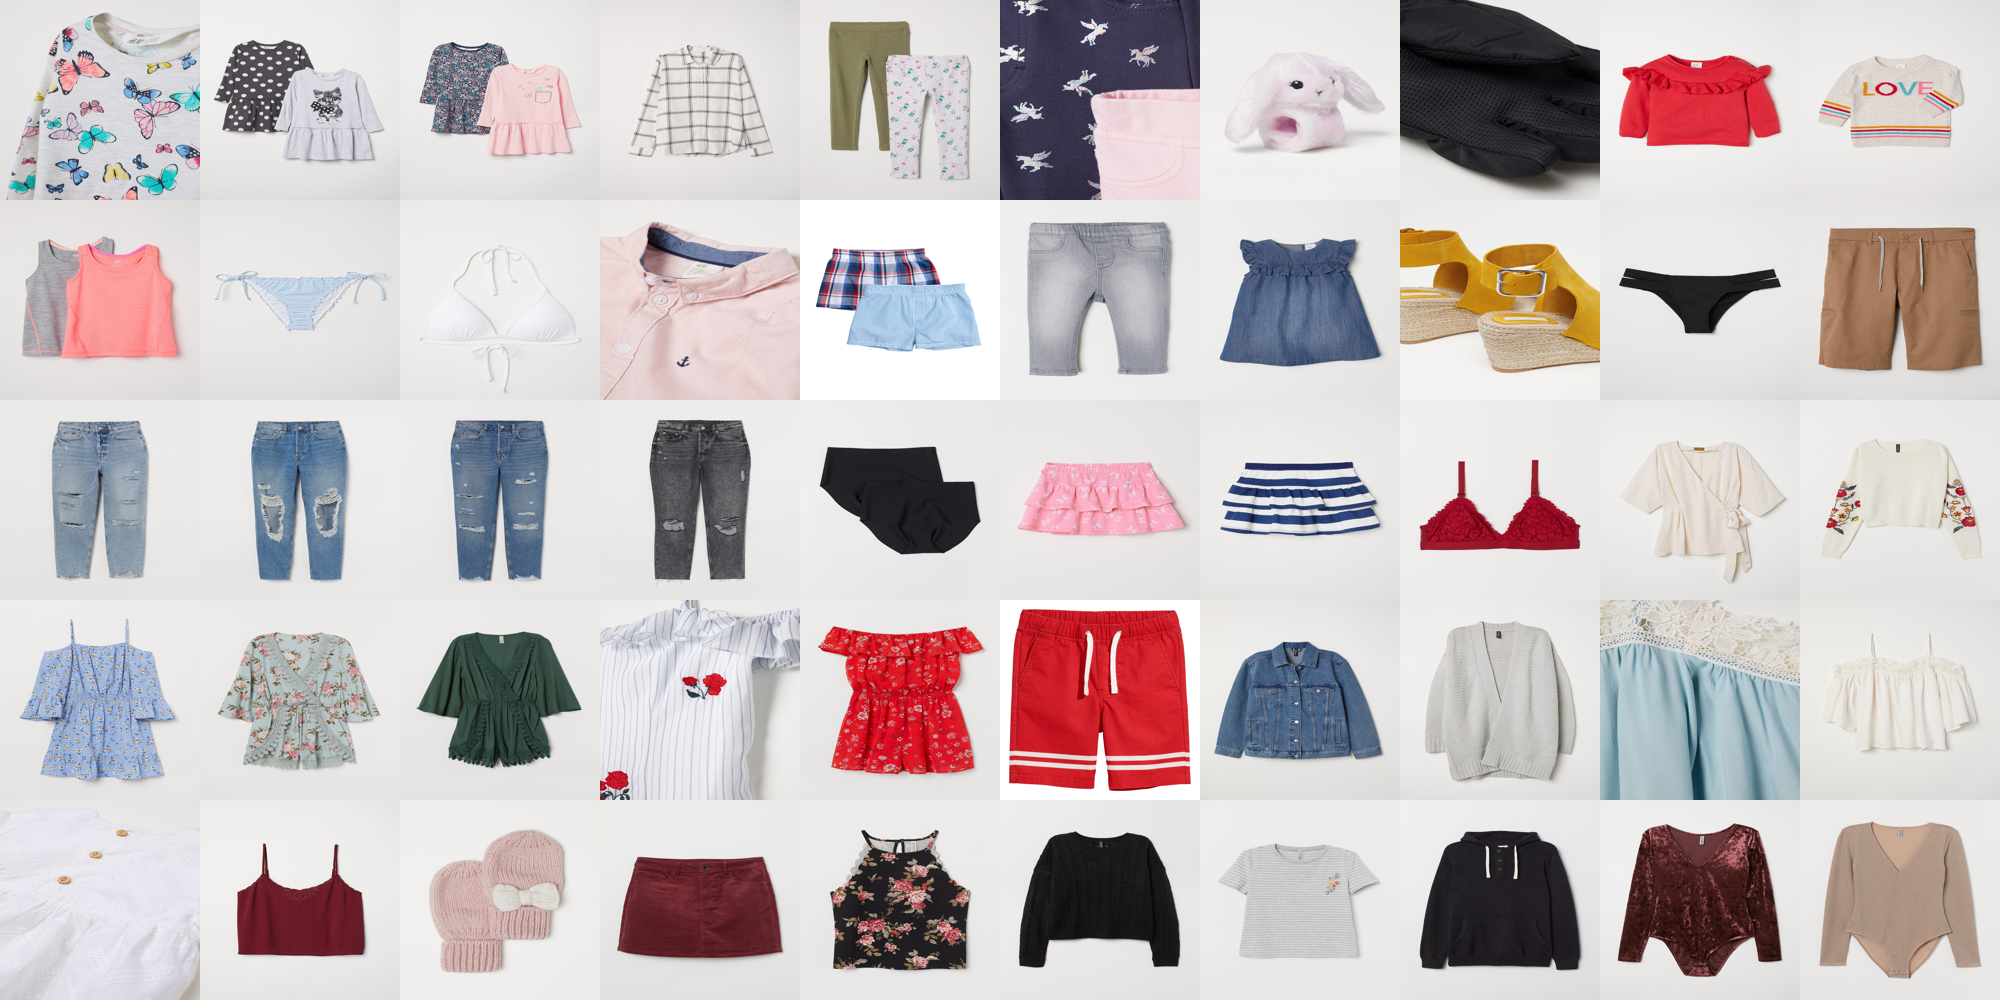

In [9]:
num_images_per_row = 10
num_images_per_col = 5

img_size = 200
start = 500
samples = image_files[start:start+(num_images_per_row * num_images_per_col)]

samples_images = Image.new('RGB',
                           (num_images_per_row * img_size, 
                            num_images_per_col * img_size))

for idx, image_file in enumerate(samples):
    img = Image.open(image_file)
    img = img.resize((img_size, img_size))
    x = (idx % num_images_per_row) * img_size
    y = (idx // num_images_per_row) * img_size
    samples_images.paste(img, (x, y))

samples_images

## 4. <a name="chapt4"></a> Loading vector embeddings

In [10]:
JSON_DIR = "json"

glob.glob(JSON_DIR + "/*.json")

['json/img_embed_19Apr2023_112639.json']

In [11]:
print("Importing vectors embeddings...")

jsonfiles = [entry.name for entry in os.scandir(JSON_DIR) if entry.is_file()]
jsonfiles = [f for f in jsonfiles if os.path.isfile(os.path.join(JSON_DIR, f))]

# Get the most recent file
modification_times = [(f, os.path.getmtime(os.path.join(JSON_DIR, f))) for f in jsonfiles]
modification_times.sort(key=lambda x: x[1], reverse=True)
most_recent_file = JSON_DIR + '/' + modification_times[0][0]

# Loading the most recent file
print(f"Loading the most recent file of the vector embeddings: {most_recent_file}")

with open(most_recent_file) as f:
    list_emb = json.load(f)

print(f"\nDone: number of imported vector embeddings = {len(list_emb):,}")

Importing vectors embeddings...
Loading the most recent file of the vector embeddings: json/img_embed_19Apr2023_112639.json

Done: number of imported vector embeddings = 1,473


## 5. <a name="chapt5"></a> Clustering

In [12]:
print("Total number of embedded catalog images =",
      "{:,}".format(len(list_emb)))

Total number of embedded catalog images = 1,473


In [13]:
# Running the kmeans on the images vector embeddings 
# and displaying the values of silhouette score

k_values = range(2, 20)
silhouette_scores = []
max_val = []

print("Performing K-Means...\n")

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=123456)
    kmeans.fit(list_emb)
    labels = kmeans.labels_
    score = silhouette_score(list_emb, labels)
    max_val.append(score)
    max_val.sort(reverse=True)
    silhouette_scores.append(score)

    print(f"For k = {k:02} => Silhouette score = {score:.5f} | Maximum score = {max_val[0]:.5f}")

Performing K-Means...

For k = 02 => Silhouette score = 0.05783 | Maximum score = 0.05783
For k = 03 => Silhouette score = 0.05136 | Maximum score = 0.05783
For k = 04 => Silhouette score = 0.04834 | Maximum score = 0.05783
For k = 05 => Silhouette score = 0.05492 | Maximum score = 0.05783
For k = 06 => Silhouette score = 0.05010 | Maximum score = 0.05783
For k = 07 => Silhouette score = 0.04882 | Maximum score = 0.05783
For k = 08 => Silhouette score = 0.04444 | Maximum score = 0.05783
For k = 09 => Silhouette score = 0.04775 | Maximum score = 0.05783
For k = 10 => Silhouette score = 0.04990 | Maximum score = 0.05783
For k = 11 => Silhouette score = 0.04802 | Maximum score = 0.05783
For k = 12 => Silhouette score = 0.05037 | Maximum score = 0.05783
For k = 13 => Silhouette score = 0.05163 | Maximum score = 0.05783
For k = 14 => Silhouette score = 0.05338 | Maximum score = 0.05783
For k = 15 => Silhouette score = 0.05443 | Maximum score = 0.05783
For k = 16 => Silhouette score = 0.0535

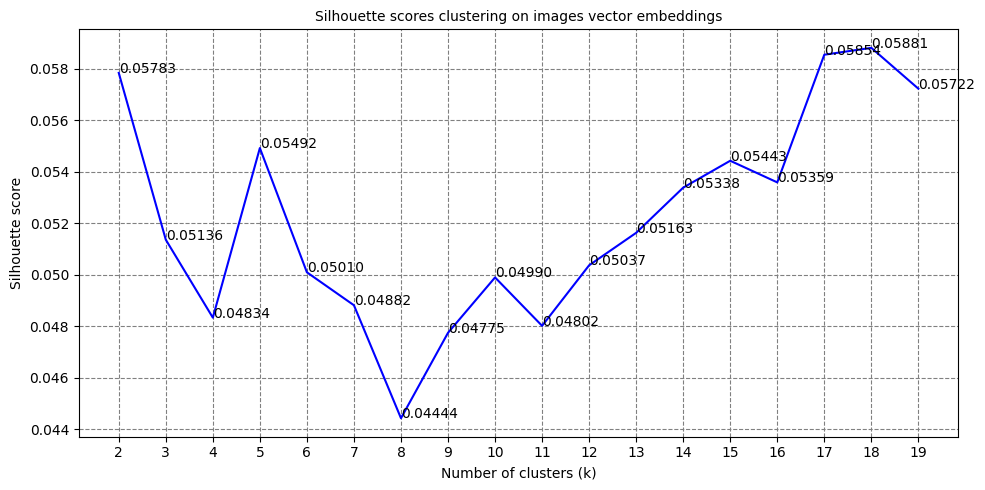

In [14]:
OUTPUT_DIR = 'output'

os.makedirs(OUTPUT_DIR, exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, color='blue')
plt.title("Silhouette scores clustering on images vector embeddings",
          size=10)
plt.grid(True, color='grey', linestyle='--')

for k, silh in zip(k_values, silhouette_scores): 
    plt.text(k, silh, f"{silh:.5f}")

plt.xticks(k_values)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'silhouette_plot.png'))
plt.show()

In [15]:
nb_clusters = 18

kmeans = KMeans(n_clusters=nb_clusters)
kmeans.fit(list_emb)
labels = kmeans.labels_

print("Cluster labels:\n", labels)
print("\nCluster centers:\n", kmeans.cluster_centers_)
print("\nWithin-cluster sum of squares (inertia) =", kmeans.inertia_)

Cluster labels:
 [14  7 12 ...  6  0  9]

Cluster centers:
 [[-1.30973484  3.08172125 -0.52514411 ... -0.02194041 -1.14118598
  -4.06138134]
 [ 0.00905153  1.72083505  0.38648979 ... -1.57523073 -2.17284621
  -5.51224617]
 [-2.7182414   2.18356796 -0.0728759  ... -1.38961519 -1.63023201
  -5.02400242]
 ...
 [-3.57041627  3.71939549 -0.56586434 ...  0.76575137 -2.82757948
  -4.88794738]
 [-0.41830765  1.7604861  -0.95176448 ... -1.04941975 -1.63248953
  -3.78780801]
 [-1.99788316  2.00481042 -1.39273423 ... -0.38023547 -0.53880169
  -4.61257128]]

Within-cluster sum of squares (inertia) = 4057670.958392257


Text(0, 0.5, 'Frequency')

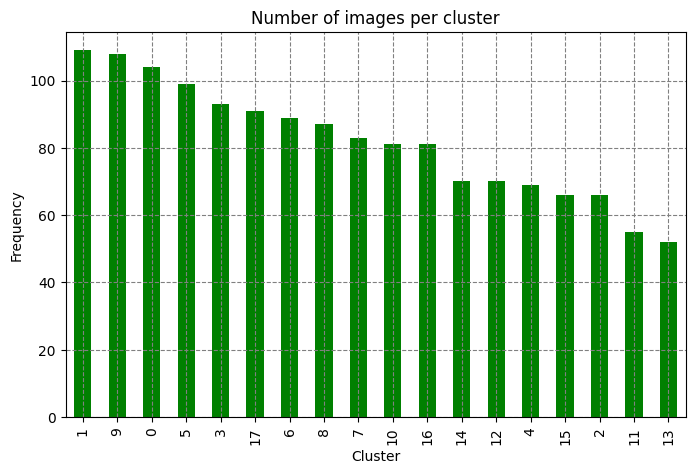

In [16]:
cluster_series = pd.Series(labels, name='cluster')

ax = cluster_series.value_counts().plot(kind='bar',
                                        figsize=(8, 5),
                                        title="Number of images per cluster",
                                        color="green")

plt.grid(True, color='grey', linestyle='--')
ax.set_xlabel("Cluster")
ax.set_ylabel("Frequency")

In [17]:
df_clusters = pd.DataFrame({'image_file': image_files,
                            'vector': list_emb,
                            'cluster': labels})

In [19]:
ipyplot.plot_class_tabs(df_clusters['image_file'],
                        df_clusters['cluster'],
                        max_imgs_per_tab=7,
                        img_width=100)

## Let's define the clusters

In [20]:
cluster_labels = [
    '0', 'Colored shirts',
    '1', 'Shirts',
    '2', 'Lingerie',
    '3', 'Children',
    '4', 'Sheets',
    '5', 'Sweatshirts',
    '6', 'Dress',
    '7', 'Trousers',
    '8', 'Woman shirts',
    '9', 'Colored shirts',
    '10', 'Coats',
    '11', 'Woman Trousers',
    '12', 'Shorts',
    '13', 'Jewelry',
    '14', 'Small articles',
    '15', 'Sportwear Trousers',
    '16', 'Glasses',
    '17', 'Colored T shirts',
]

In [21]:
cluster_ids = [
    int(cluster_labels[i]) for i in range(0, len(cluster_labels), 2)
]
category_names = [
    cluster_labels[i + 1] for i in range(0, len(cluster_labels), 2)
]

cluster_ids_series = pd.Series(cluster_ids, name='cluster')
cluster_names_series = pd.Series(category_names, name='cluster_label')
cluster_labels_df = pd.concat([cluster_ids_series, cluster_names_series],
                              axis=1)
df_results = pd.merge(df_clusters, cluster_labels_df, on='cluster', how='left')
# Adding 1 to avoid the number 0
df_results['cluster'] = df_results['cluster'].apply(lambda x: int(x) + 1)
# Numbers in 2 characters
df_results['cluster'] = df_results['cluster'].apply(lambda x: f'0{x}' if int(x) < 10 else x)
# Adding some text
df_results['cluster'] = df_results['cluster'].astype(str)
df_results['Cluster and Label'] = 'Cluster ' + df_results['cluster'] + ' = ' + df_results[
    'cluster_label']
df_results

,image_file,vector,cluster,cluster_label,Cluster and Label
0,fashion/0391032009.jpg,"[-3.864301, 2.6202242, -1.5379283, -3.0021067,...",15,Small articles,Cluster 15 = Small articles
1,fashion/0391750016.jpg,"[-2.9103844, 3.2787294, 0.078209564, -0.000789...",08,Trousers,Cluster 08 = Trousers
2,fashion/0392168001.jpg,"[-1.1405776, 2.8282518, -1.4665827, -3.0258274...",13,Shorts,Cluster 13 = Shorts
3,fashion/0392269012.jpg,"[-1.9203011, 1.5792967, -3.5268962, -2.750633,...",18,Colored T shirts,Cluster 18 = Colored T shirts
4,fashion/0392938035.jpg,"[0.24055481, 1.2346196, 1.6844418, -1.8438998,...",02,Shirts,Cluster 02 = Shirts
...,...,...,...,...,...
1468,fashion/0699923102.jpg,"[0.844161, 2.3453286, -1.8638413, -3.6870139, ...",18,Colored T shirts,Cluster 18 = Colored T shirts
1469,fashion/0699923113.jpg,"[-2.8149629, 1.7937542, -4.461116, -5.139367, ...",18,Colored T shirts,Cluster 18 = Colored T shirts
1470,fashion/0699930005.jpg,"[-1.9891852, 5.2243, -1.5902903, -1.7792684, 5...",07,Dress,Cluster 07 = Dress
1471,fashion/0699934001.jpg,"[-1.2933745, 3.8007476, -1.1640947, -0.6120443...",01,Colored shirts,Cluster 01 = Colored shirts


In [22]:
# Saving the results in a json file
df_results.to_json(os.path.join(OUTPUT_DIR, "clusters.json"))

Text(0, 0.5, 'Frequency')

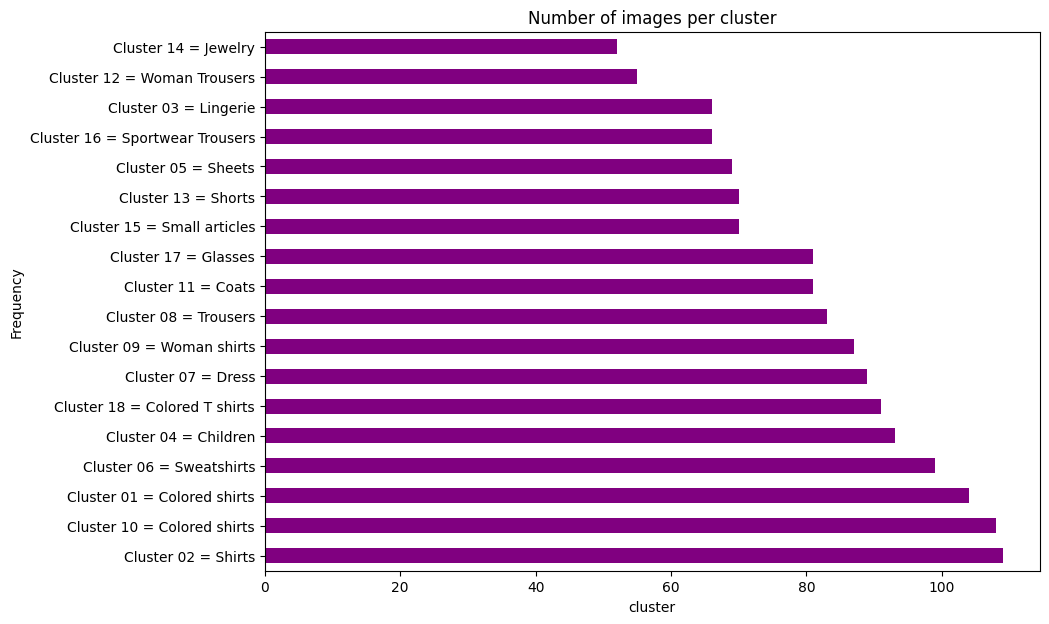

In [23]:
ax = df_results['Cluster and Label'].value_counts().plot(
    kind='barh',
    figsize=(10, 7),
    title="Number of images per cluster",
    color="purple"
)

ax.set_xlabel("cluster")
ax.set_ylabel("Frequency")

In [24]:
ipyplot.plot_class_tabs(df_results['image_file'],
                        df_results['Cluster and Label'],
                        max_imgs_per_tab=7,
                        img_width=100)

## 6 Clustering analysis

https://atlas.nomic.ai/

During indexing, **Atlas builds a contextual two-dimensional data map of embeddings**. 
This map preserves high-dimensional relationships present between embeddings in a two-dimensional,
human interpretable view.

You can get a free key at https://atlas.nomic.ai/cli-login

In [25]:
load_dotenv("visualsearch.env")

atlas_nomic_key = os.getenv('atlas_nomic_key')
nomic.login(atlas_nomic_key)

In [26]:
clusterlabel = df_results['cluster_label'].tolist()

datapoints = [{'filename': image_file_name, 'id': i, 'clusterlabel': clusterlabel[i]}
              for i, image_file_name in enumerate(image_files)]

project = atlas.map_embeddings(
    embeddings=np.array(list_emb),  # images vector embeddings
    data=datapoints, # datapoints
    id_field="id",  # id
    name="image_file_name",  # image filename
    colorable_fields=['clusterlabel'],  # cluster label
    reset_project_if_exists=True,
    is_public=True,  # public map
)

map = project.get_map("Clustering images vector embeddings with Azure Computer Vision 4")
print(map)

project.maps[0]

2023-04-19 11:40:07.459 | INFO     | nomic.project:__init__:871 - Found existing project `image_file_name` in organization `seretkow`. Clearing it of data by request.
2023-04-19 11:40:08.206 | INFO     | nomic.project:_create_project:965 - Creating project `image_file_name` in organization `seretkow`
2023-04-19 11:40:09.842 | INFO     | nomic.atlas:map_embeddings:100 - Uploading embeddings to Atlas.
2023-04-19 11:40:09.870 | WARNING  | nomic.project:_validate_and_correct_arrow_upload:244 - id_field is not a string. Converting to string from int32
1it [00:02,  2.88s/it]
2023-04-19 11:40:12.758 | INFO     | nomic.project:_add_data:1577 - Upload succeeded.
2023-04-19 11:40:12.759 | INFO     | nomic.atlas:map_embeddings:119 - Embedding upload succeeded.
2023-04-19 11:40:14.239 | INFO     | nomic.project:create_index:1282 - Created map `image_file_name` in project `image_file_name`: https://atlas.nomic.ai/map/388ed80b-7d48-4cfd-abc6-125206d56ff8/f4e39a1d-7865-456b-b18b-fd991e8c8d07
2023-04-

image_file_name: https://atlas.nomic.ai/map/388ed80b-7d48-4cfd-abc6-125206d56ff8/f4e39a1d-7865-456b-b18b-fd991e8c8d07


image_file_name: https://atlas.nomic.ai/map/388ed80b-7d48-4cfd-abc6-125206d56ff8/f4e39a1d-7865-456b-b18b-fd991e8c8d07

### We have a map like that one. Each point is an image. Each color is a cluster.

<img src="https://github.com/retkowsky/images/blob/master/florence/map2.png?raw=true">

### These two images were close on the map. They are quite similar (same kind of shoes)

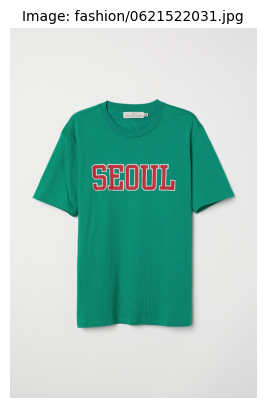

In [27]:
view_image("fashion/0621522031.jpg")

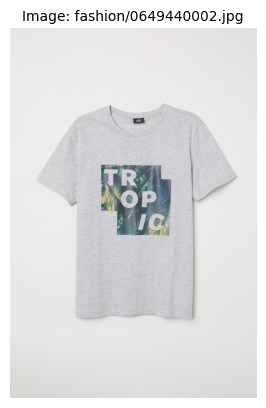

In [28]:
view_image("fashion/0649440002.jpg")

> End